In [1]:
!pip install pyrsgis
from pyrsgis import raster, convert
from osgeo import gdal
from google.colab import drive
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from sklearn.metrics import confusion_matrix, precision_score, recall_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
multispectral_Bangalore = '/content/drive/MyDrive/Dataset_Satellite/Bangalore_2013_clip.tif'
classes_Bangalore = '/content/drive/MyDrive/Dataset_Satellite/classified_2013.tif'
multispectral_Bangalore_2011 = '/content/drive/MyDrive/Dataset_Satellite/Bangalore_2011_clip.tif'

In [4]:
ds1, features = raster.read(multispectral_Bangalore, bands = 'all')
print('Bangalore Multispectral image shape', features.shape)

ds2, labels = raster.read(classes_Bangalore, bands = 1)
print('Bangalalore mutliclass image shape', labels.shape)

ds3, features_2011 = raster.read(multispectral_Bangalore_2011, bands = 'all')
print('Bangalore 2011 multispectral image shape', features_2011.shape)

Bangalore Multispectral image shape (6, 2068, 2268)
Bangalalore mutliclass image shape (2068, 2268)
Bangalore 2011 multispectral image shape (6, 2054, 2044)


In [5]:
featuresBangalore = convert.array_to_table(features)
labelBangalore = convert.array_to_table(labels)
featuresBangalore_2011 = convert.array_to_table(features_2011)
nBands = features.shape[1]

for i in range(1,5):
  labels = (labels == i).astype(int)

In [6]:
print('Reshaped Bangalore data with features ',featuresBangalore.shape)
print('Reshaped Bangalore data with labels', labelBangalore.shape)
print('Reshaped bangalore data with features of 2011', featuresBangalore_2011.shape)


Reshaped Bangalore data with features  (4690224, 6)
Reshaped Bangalore data with labels (4690224,)
Reshaped bangalore data with features of 2011 (4198376, 6)


In [7]:
xTrain, xTest, yTrain, yTest = train_test_split(featuresBangalore, labelBangalore, test_size=0.4,random_state=42)

'''
for i in range(len(yTrain)):
      if(yTrain[i]!=0):  
        yTrain[i] -= 1
'''

print(xTrain.shape)
print(np.amax(xTrain))
print(np.amax(yTrain))
print(np.amax(featuresBangalore_2011))

(3752179, 6)
65535
4
255


In [8]:
xTrain = xTrain / 35355.0
xTest = xTest / 35355.0
featuresBangalore_2011 = featuresBangalore_2011/255.0
print(np.min(xTrain),np.max(xTrain))
print(np.min(yTrain),np.max(yTrain))
print(np.max(xTest))


xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))
featuresBangalore_2011 = featuresBangalore_2011.reshape((featuresBangalore_2011.shape[0], 1, featuresBangalore_2011.shape[1]))
print(xTrain.shape, xTest.shape)

0.07385815928391094 1.0027541886619233
1 4
1.0027541886619233
(3752179, 1, 6) (938045, 1, 6)


In [9]:
nBands = featuresBangalore.shape[1]

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(11,activation = 'relu'),
    keras.layers.Dense(7,activation = 'relu'),
    keras.layers.Dense(4, activation='softmax')])

model.compile(optimizer="adam", loss = "sparse_categorical_crossentropy", metrics= ['accuracy'] )


In [10]:
history = model.fit(xTrain,yTrain,epochs=1)

117256/117256 [==============================] - 227s 2ms/step - loss: 0.1303 - accuracy: 0.9536


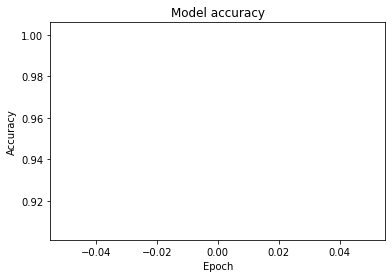

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()


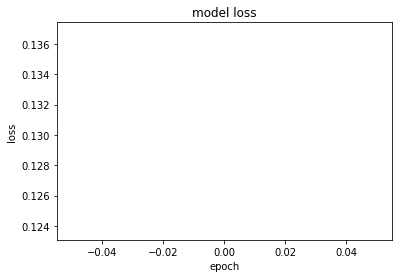

In [12]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [13]:
predicted = model.predict(featuresBangalore_2011)
prediction = convert.table_to_array(predicted, n_rows=ds3.RasterYSize, n_cols=ds3.RasterXSize)
outFile = 'Bangalore_2011_predicted.tif'
raster.export(prediction, ds3, filename=outFile, dtype='float')

In [ ]:
print(predicted.shape)
prediction.size

(4198376, 4)


16793504